# Time Series Anomaly Detection With Autoencoders & LSTMs

In this notebook, we will train a LSTM autoencoder model for detection anomalies over heartbeats, using PyTorch.

## About Dataset
This dataset contains a set of N = 5000 univariate time series with 140 timesteps (T = 140).  Each sequence corresponds to one heartbeat. Five classes are annotated, corresponding to the following labels: Normal (N), R-on-T Premature Ventricular Contraction (R-on-T PVC), Premature Ventricular Contraction (PVC), Supra-ventricular Premature or Ectopic Beat (SP or EB) and Unclassified Beat (UB). 

[Dataset Decription Link 1](https://link.springer.com/article/10.1007%2Fs10618-014-0388-4)

[Dataset Description Link 2](https://ieeexplore.ieee.org/document/8679157)

## Preparation

In [1]:
%%capture
!pip install arff2pandas
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import (confusion_matrix, classification_report, 
                             f1_score, accuracy_score)
from sklearn.model_selection import train_test_split

from glob import glob
import time
import copy
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from multiprocess import cpu_count

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset

from arff2pandas import a2p
from collections import defaultdict

from transformers import get_linear_schedule_with_warmup, AdamW

from tqdm.auto import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 10, 4

Seed everything!

In [4]:
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(RANDOM_SEED)

Initialize the device.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


Load the dataset.

In [6]:
base_path = "/content/drive/MyDrive/Applied AI #6 Source/data/ECG5000/"
with open(base_path + "ECG5000_TRAIN.arff") as f:
    train = a2p.load(f)

with open(base_path + "ECG5000_TEST.arff") as f:
    test = a2p.load(f)

In [7]:
train.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.40638

In [8]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [9]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [10]:
class_names = ['Normal','R on T','PVC','SP','UB']

In [11]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

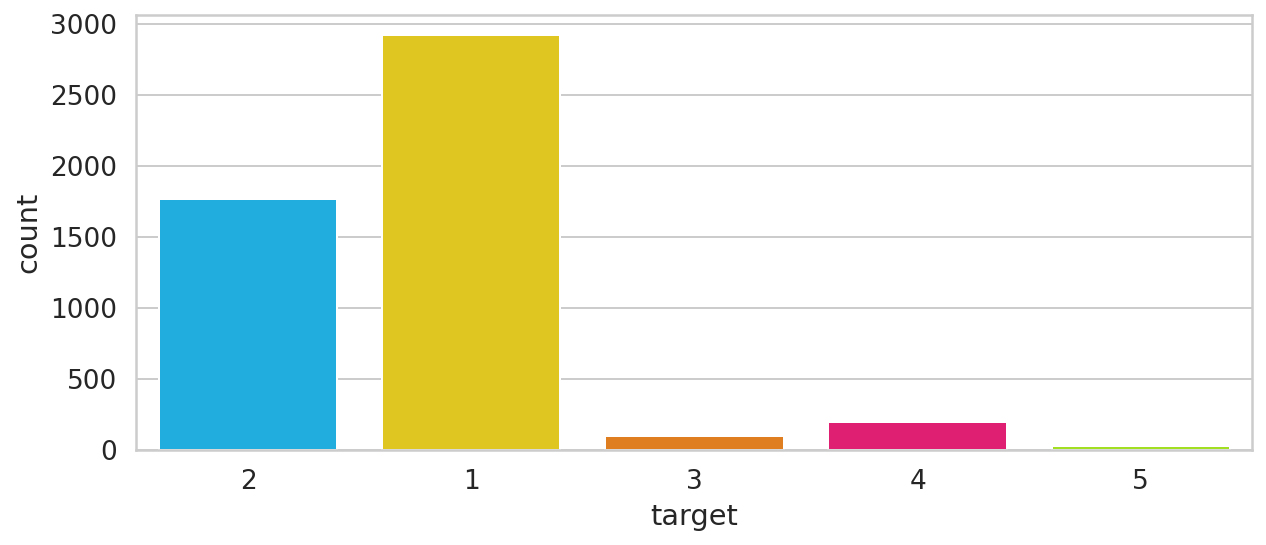

In [12]:
ax = sns.countplot(df.target)

* Normal: 1
* R-on-T Premature Ventricular Contradiction (R-on-T PVC): 2
* Prematyre Ventricular Contraction (PVC): 3
* Supra-venctricular Premature or Ectopic Beat (SP or EB): 4
* Unclassified Beat (UB): 5

# Preprocessing

In [13]:
CLASS_NORMAL = 1
normal_df = df[df["target"] == str(CLASS_NORMAL)].drop(labels="target", axis=1)
print(normal_df.shape)

(2919, 140)


In [14]:
anomaly_df = df[df["target"] != str(CLASS_NORMAL)].drop(labels="target", axis=1)
print(anomaly_df.shape)

(2081, 140)


In [15]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size = 0.33, random_state=RANDOM_SEED)
print(train_df.shape, val_df.shape, test_df.shape)

(2481, 140) (293, 140) (145, 140)


We wrote a PyTorch dataset class before. We can create a dataset without it, by ```TensorDataset``` and ```RandomSampler```.

In [16]:
BATCH_SIZE = 16
SEQ_LEN = 140
N_FEATURES = 1

def train_dataset(df,batch_size):
    torch_df = torch.tensor(df.to_numpy())
    train_data = TensorDataset(torch_df)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

def test_dataset(df, batch_size):
    torch_df = torch.tensor(df.to_numpy())
    val_data = TensorDataset(torch_df)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
    return val_dataloader

train_dataloader = train_dataset(train_df, BATCH_SIZE)
val_dataloader = test_dataset(val_df, BATCH_SIZE)
test_dataloader = test_dataset(test_df, BATCH_SIZE)
anomaly_dataloader = test_dataset(anomaly_df, 1)

print(next(iter(train_dataloader))[0].shape)
print(next(iter(val_dataloader))[0].shape)
print(next(iter(test_dataloader))[0].shape)
print(next(iter(anomaly_dataloader))[0].shape)

torch.Size([16, 140])
torch.Size([16, 140])
torch.Size([16, 140])
torch.Size([1, 140])


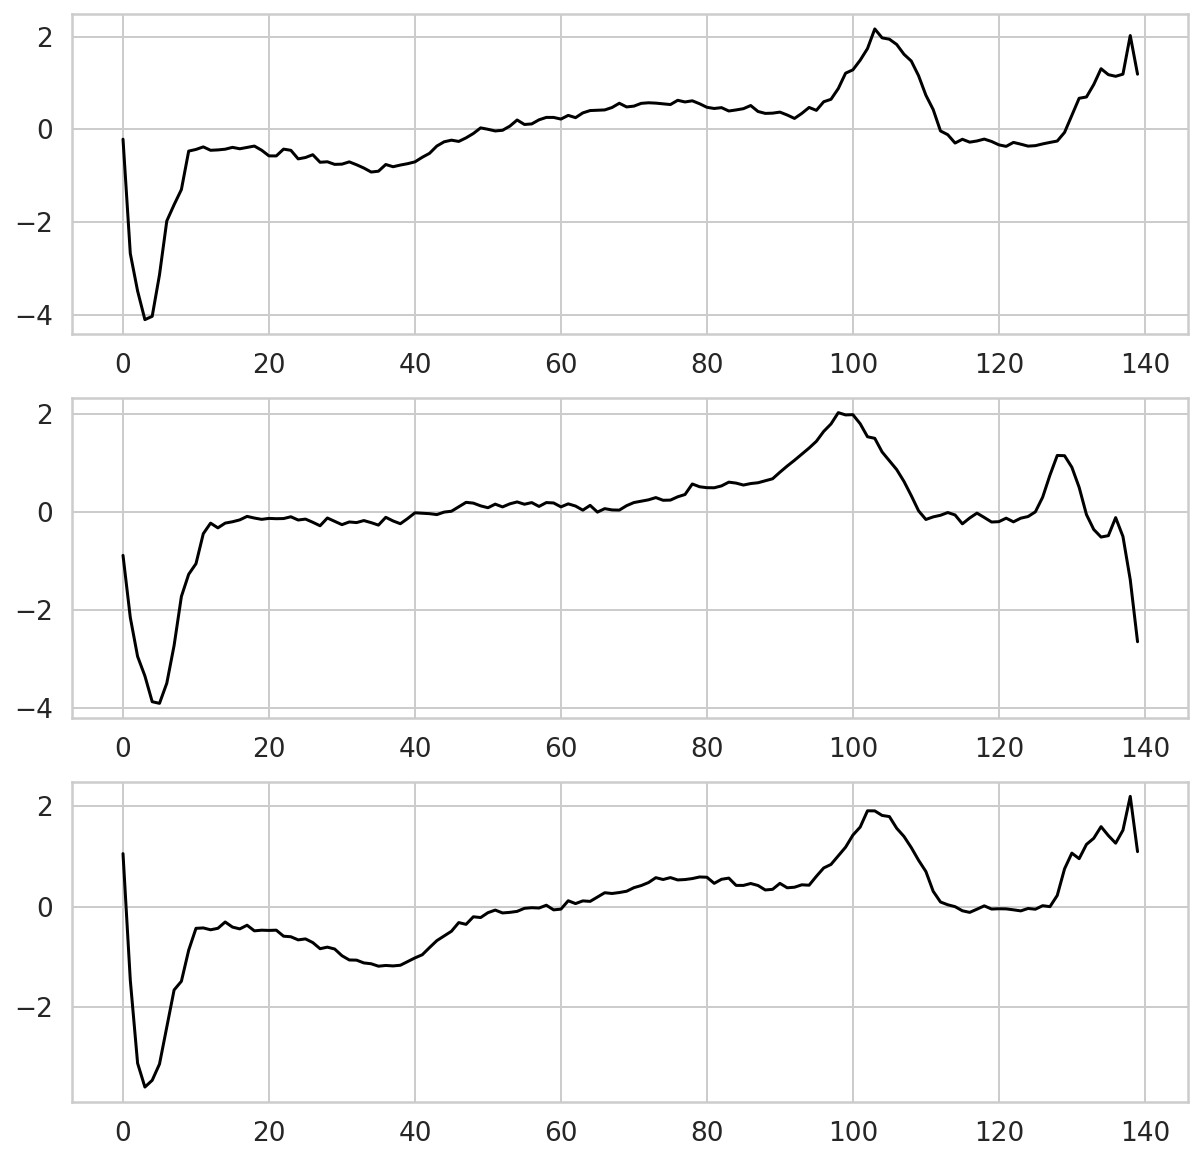

In [17]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
samples = torch.randint(0, 16, (3,))
axs[0].plot(next(iter(train_dataloader))[0][samples[0]].numpy(), color="black")
axs[1].plot(next(iter(train_dataloader))[0][samples[1]].numpy(), color="black")
axs[2].plot(next(iter(train_dataloader))[0][samples[2]].numpy(), color="black");

# Model

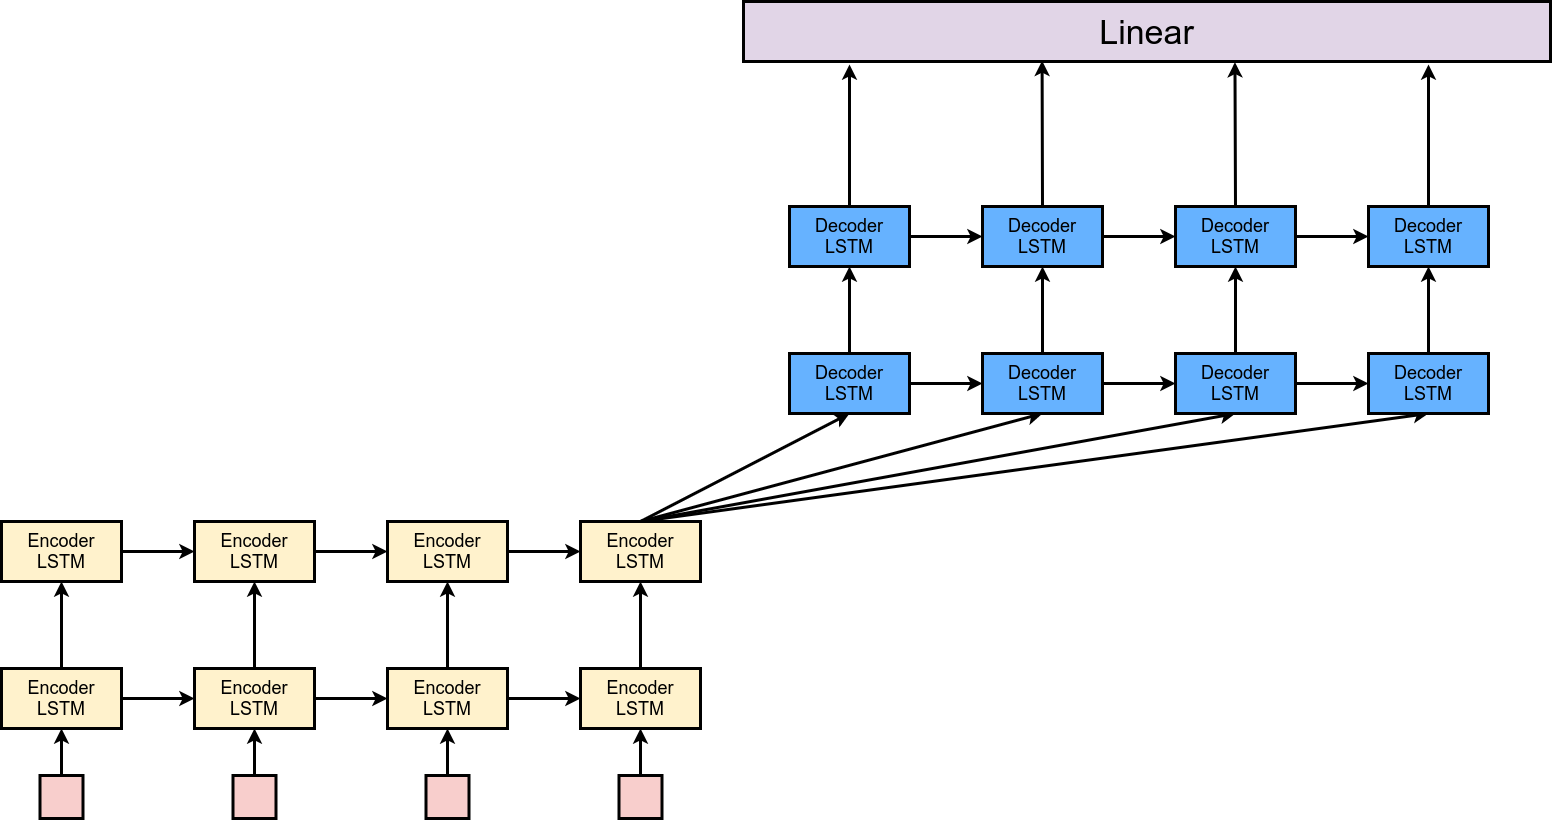

In [18]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, hidden_dim = 64):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim_1 = hidden_dim
        self.hidden_dim_2 = hidden_dim * 2
        
        self.lstm1 = nn.LSTM(
            input_size = n_features,
            hidden_size = self.hidden_dim_2,
            num_layers = 1,
            batch_first = True
        )
        
        self.lstm2 = nn.LSTM(
            input_size = self.hidden_dim_2,
            hidden_size = self.hidden_dim_1,
            num_layers = 1,
            batch_first = True
        )
        
    def forward(self, x):
        # x: [B, seq_len] == [B, 140]
        x = torch.unsqueeze(x, dim = 2).float()
        # x = x[:,:,None].float()
        
        out, (hidden, _) = self.lstm1(x)
        #[B, seq_len, hidden_dim_1]
        out, (hidden, _) = self.lstm2(out)
        #[1, B, hidden_dim_2]
        
        out = torch.squeeze(hidden, dim = 0)
        # [B, hidden_dim_2]
        return out

In [19]:
class Decoder(nn.Module):
    def __init__(self, seq_len, n_features = 1, encoder_hidden_dim = 64):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        
        self.encoder_hidden_dim = encoder_hidden_dim
        self.hidden_dim = encoder_hidden_dim * 2
        
        self.lstm1 = nn.LSTM(
            input_size = encoder_hidden_dim,
            hidden_size = encoder_hidden_dim,
            num_layers = 1,
            batch_first = True
        )
        
        self.lstm2 = nn.LSTM(
            input_size = encoder_hidden_dim,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True
        )
        
        self.fcn = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        # x: [B, encoder_hidden_dim]
        batch_size = x.size(0)
        
        x = x.repeat(self.seq_len, self.n_features)
        
        # x: [B * seq_len, encoder_hidden_dim]
        x = x.reshape(batch_size, -1, self.encoder_hidden_dim)
        
        # x: [B, seq_len, encoder_hidden_dim]
        
        x, (hidden, _) = self.lstm1(x)
        x, (hidden, _) = self.lstm2(x)
        x = self.fcn(x)
        # self.hidden_dim -> 1
        #[b, 140, 1]
        x = torch.squeeze(x, dim = -1)
        return x

In [20]:
class LSTMAE(nn.Module):
    def __init__(self, seq_len, n_features, device, hidden_dim = 64):
        super(LSTMAE, self).__init__()
        
        self.encoder = Encoder(seq_len, n_features, hidden_dim).to(device)
        self.decoder = Decoder(seq_len, n_features, hidden_dim).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
model = LSTMAE(SEQ_LEN, N_FEATURES, device, hidden_dim = 128).to(device)

In [22]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of trainable parameters: {params}")

Number of trainable parameters: 990465


In [23]:
print(model)

LSTMAE(
  (encoder): Encoder(
    (lstm1): LSTM(1, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (fcn): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [24]:
model(next(iter(anomaly_dataloader))[0].to(device)).shape

torch.Size([1, 140])

# Training

In [42]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, device,
         EPOCHS, EVALUATE_EVERY, scheduler = None, gradient_clipping = False,
         gradient_clipping_rate = 1., evaluate_epoch = False):
    
    model = model.to(device)
    total = len(train_dataloader) * EPOCHS
    log = defaultdict(list)
    log["train_loss"] = []
    log["eval_loss"] = []
    loss_a = []
    
    with tqdm(total = total, desc="Training Round") as tt:
        for epoch in range(EPOCHS):
            total_loss, batch_loss, batch_counts = 0, 0, 0
            for step, batch in enumerate(train_dataloader):
                model.train()
                batch_counts += 1
                b_inputs, = tuple(t.to(device) for t in batch)
                
                optimizer.zero_grad()
                
                out = model(b_inputs)
                loss = criterion(out, b_inputs)
                
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                
                loss_a.append(loss.item())
                
                if gradient_clipping:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping_rate)
                
                if scheduler != None:
                    scheduler.step()
                tt.update()
                    
            if evaluate_epoch:
                val_loss = evaluate(model, criterion, val_dataloader, device)
                print(30*"*")
                print(f"{epoch+1}/{EPOCHS}:")
                print(f"  - Train Loss: {np.mean(loss_a)}")
                print(f"  - Validation Loss: {val_loss}")
                log["train_loss"].append(total_loss / len(train_dataloader))
                log["eval_loss"].append(val_loss)
                if log["eval_loss"][np.argmin(log["eval_loss"])] == val_loss:
                  print(f"Best model is stored with eval loss {val_loss}.")
                  best_model = model
        print("Done.")
        tt.close()
    return model, best_model, log
                

In [43]:
def evaluate(model, criterion, val_dataloader, device):
  total = len(val_dataloader)
  loss_a = []
  with tqdm(total = total, leave=False, position=0, desc="Validation Round") as ee:
    val_loss, val_batch_loss, val_batch_counts = 0, 0, 0
    for step, batch in enumerate(val_dataloader):
      model.eval()
      val_batch_loss += 1
      b_inputs, = tuple(t.to(device) for t in batch)
      
      with torch.no_grad():
        out = model.forward(b_inputs)

      loss = criterion(out, b_inputs)
      loss_a.append(loss.detach().cpu().numpy())
      #val_batch_loss += loss.item()
      #val_loss += loss.item()
      ee.update()
    ee.close()
  #return val_loss/total
  return np.mean(loss_a)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.L1Loss(reduction="sum")
EPOCHS = 10
EVALUATE_EVERY = 100

optimizer = AdamW(
    model.parameters(),
    lr=0.0005,
    eps=1e-9,
    betas = (0.9, 0.98)
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * 5
)

In [45]:
model, best_model, log = train(
    model = model,
    optimizer = optimizer, 
    criterion = criterion, 
    train_dataloader = train_dataloader, 
    val_dataloader = val_dataloader, 
    device = device, 
    EPOCHS = EPOCHS, 
    EVALUATE_EVERY = EVALUATE_EVERY, 
    evaluate_epoch=True
)

Training Round:   0%|          | 0/1560 [00:00<?, ?it/s]

Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
1/10:
  - Train Loss: 1279.7326009456929
  - Validation Loss: 1096.3546142578125
Best model is stored with eval loss 1096.3546142578125.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
2/10:
  - Train Loss: 1154.640909268306
  - Validation Loss: 872.4956665039062
Best model is stored with eval loss 872.4956665039062.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
3/10:
  - Train Loss: 1065.9067034925151
  - Validation Loss: 871.1947021484375
Best model is stored with eval loss 871.1947021484375.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
4/10:
  - Train Loss: 1019.6804057267996
  - Validation Loss: 839.80908203125
Best model is stored with eval loss 839.80908203125.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
5/10:
  - Train Loss: 980.9084903717041
  - Validation Loss: 754.2277221679688
Best model is stored with eval loss 754.2277221679688.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
6/10:
  - Train Loss: 929.9854487985627
  - Validation Loss: 693.5830688476562
Best model is stored with eval loss 693.5830688476562.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
7/10:
  - Train Loss: 905.226952620915
  - Validation Loss: 777.0593872070312


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
8/10:
  - Train Loss: 888.0162309331772
  - Validation Loss: 606.08251953125
Best model is stored with eval loss 606.08251953125.


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
9/10:
  - Train Loss: 861.8725644380619
  - Validation Loss: 609.6063232421875


Validation Round:   0%|          | 0/19 [00:00<?, ?it/s]

******************************
10/10:
  - Train Loss: 840.6860397045428
  - Validation Loss: 620.411865234375
Done.


In [46]:
torch.save(best_model.state_dict(), "/content/drive/MyDrive/Applied AI #6 Source/Time Series/anomaly_ckpts/best_model.pt")
torch.save(model.state_dict(), "/content/drive/MyDrive/Applied AI #6 Source/Time Series/anomaly_ckpts/model.pt")

In [47]:
model = LSTMAE(SEQ_LEN, N_FEATURES, device, hidden_dim = 128).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Applied AI #6 Source/Time Series/anomaly_ckpts/best_model.pt"))

<All keys matched successfully>

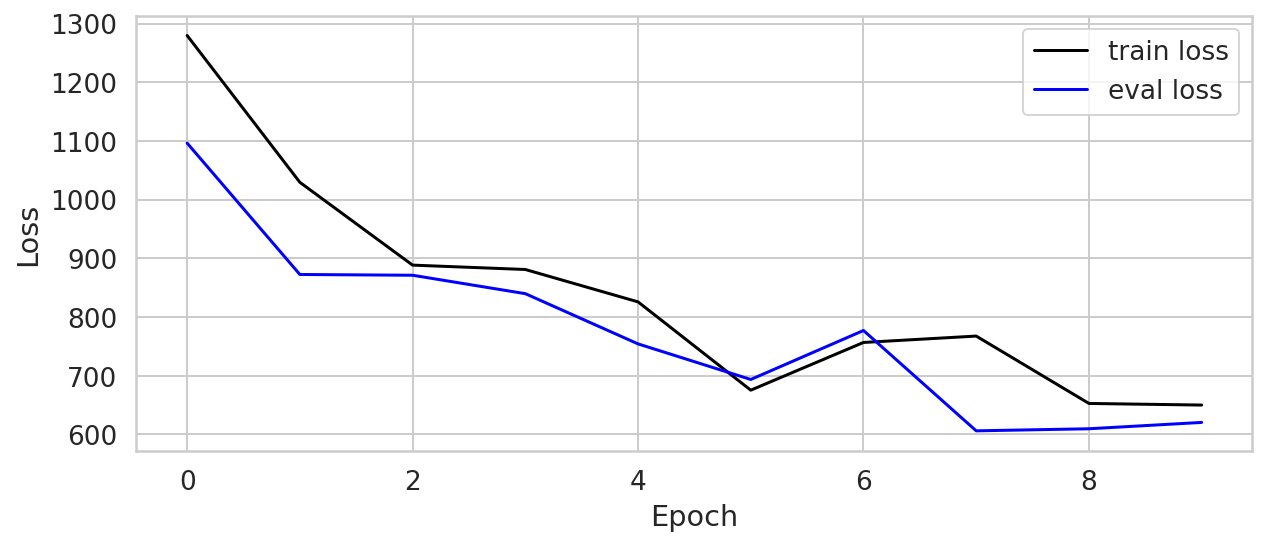

In [48]:
plt.plot(log["train_loss"], label = "train loss", color = "black")
plt.plot(log["eval_loss"], label = "eval loss", color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation

In [49]:
def thresholding(model, criterion, dataset, device):
  preds, losses = [], []
  total = len(dataset)
  dataset = train_dataset(dataset, 1)
  with tqdm(total = total) as ee:
    with torch.no_grad():
      for step, batch in enumerate(dataset):
        model.eval()
        b_inputs, = tuple(t.to(device) for t in batch)
        out = model.forward(b_inputs)

        loss = criterion(out, b_inputs)

        preds.append([out.detach().cpu().numpy(), b_inputs.cpu().numpy()])
        losses.append(loss.detach().cpu().numpy())
        ee.update()
    ee.close()

  return preds, losses

In [50]:
reconstructions, losses = thresholding(model, criterion, train_df, device)

  0%|          | 0/2481 [00:00<?, ?it/s]

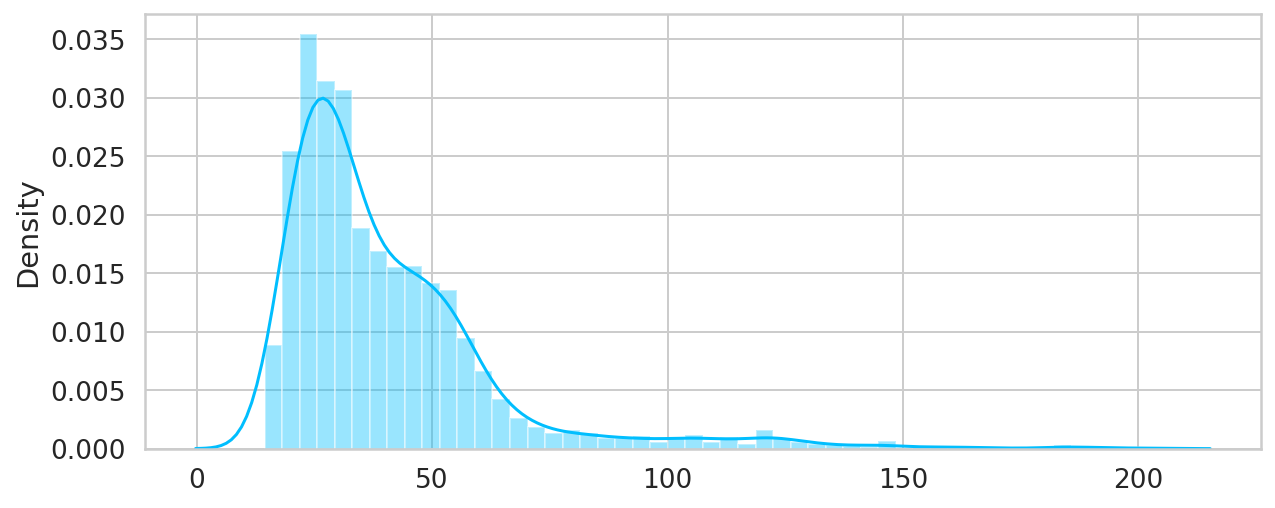

In [51]:
sns.distplot(losses, bins=50, kde=True);

In [52]:
threshold = np.mean(losses)
print(threshold)

40.491


In [53]:
def torch_classification_report(model, criterion, df_all, 
                                device, threshold, print_report = True, disable=False):
  all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all["target"].to_numpy()))
  all_sampler = SequentialSampler(all_data)
  all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
  total = len(all_dataloader)
  preds = []
  targets = []
  with tqdm(total = total, disable=disable) as ee:
    with torch.no_grad():
      for step, batch in enumerate(all_dataloader):
        model.eval()
        b_inputs, b_targets = tuple(t.to(device) for t in batch)
        out = model.forward(b_inputs)
        loss = criterion(out, b_inputs)

        targets.append(b_targets.item())

        if loss> threshold:
          preds.append(1)
        else:
          preds.append(0)
        ee.update()
    ee.close()
  f1 = f1_score(targets, preds)
  acc = accuracy_score(targets, preds)
  if print_report:
    print(classification_report(targets, preds))
  return acc, f1

def density_classification_report(model, criterion, df_all, device, losses, disable):
  f1s = []
  accs = []
  for loss in losses:
    acc, f1 = torch_classification_report(
        model = model, 
        criterion = criterion, 
        df_all = df_all, 
        device = device, 
        threshold = loss, 
        print_report = False, 
        disable = disable
    )
    f1s.append(f1)
    accs.append(acc)
  return accs, f1s

In [54]:
anomaly_df = anomaly_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)
anomaly_df["target"] = 1
test_df["target"] = 0

all_df = pd.concat([anomaly_df,test_df]).reset_index(drop = True)

In [55]:
acc, f1 = torch_classification_report(model, criterion, all_df, device, threshold, disable=False)

  0%|          | 0/2226 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       145
           1       0.98      1.00      0.99      2081

    accuracy                           0.98      2226
   macro avg       0.97      0.86      0.91      2226
weighted avg       0.98      0.98      0.98      2226



In [56]:
print(f"Accuracy: {acc}\nF1: {f1}")

Accuracy: 0.9797843665768194
F1: 0.9892831626577757


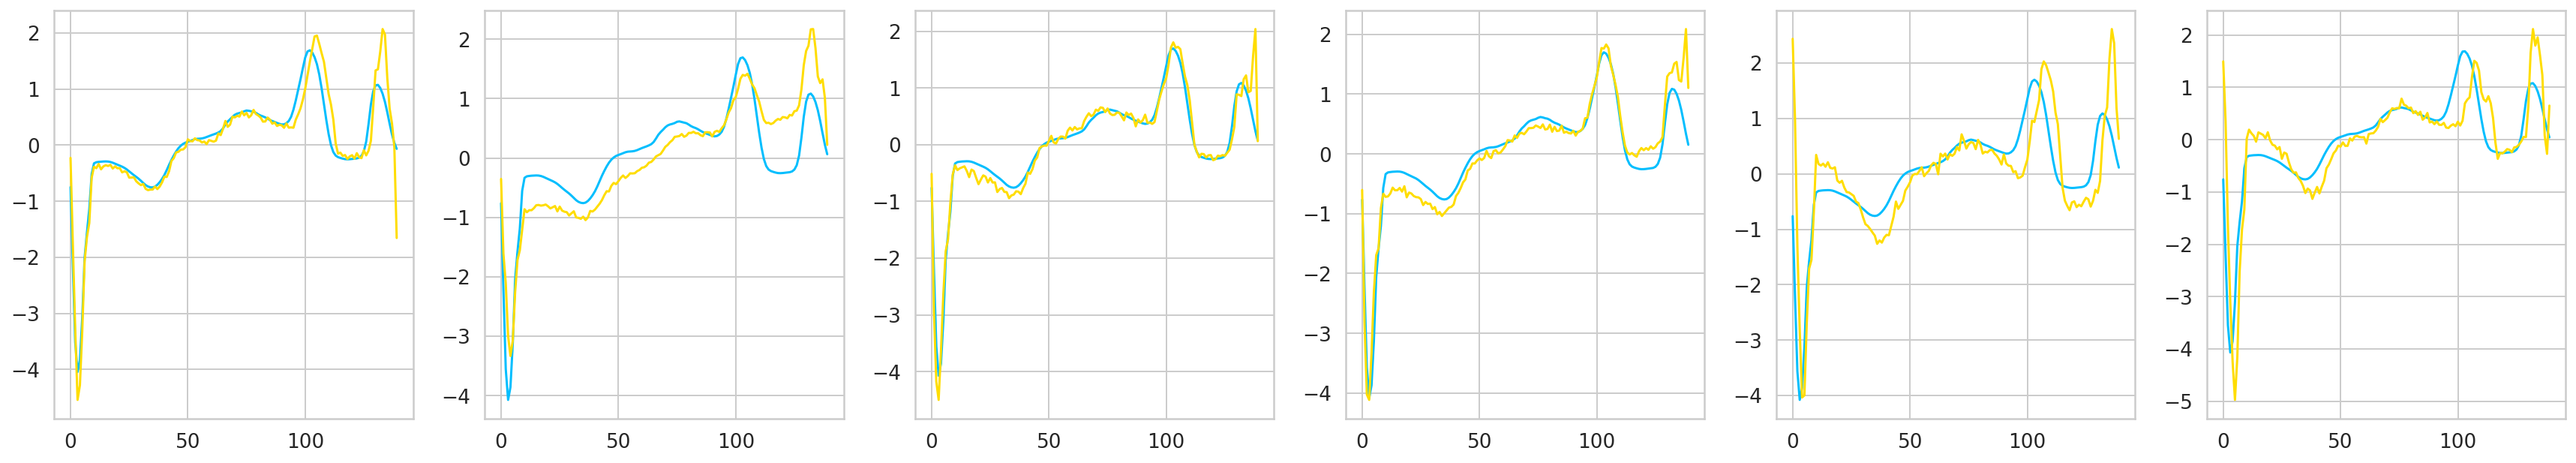

In [58]:
fig, axs = plt.subplots(1,6,figsize=(30,5))

for i in range(6):
  axs[i].plot(reconstructions[i][0][0,:])
  axs[i].plot(reconstructions[i][1][0,:])